In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html

# Analise de UPAC com bateria

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

In [2]:
# Parametros do projecto
nome_projecto = 'Exemplo_600W'
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 2400 # kWh, exemplo consumo médio 200 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
capacidade_instalada = 0.6 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 38.716
lon = -9.148
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Analise energetica
# =====================
analise_com_bateria = True
capacidade_bat = 1.2 # kWh
soc_min = 20 # limite maximo descarregamento em % 
soc_max = 80 # limite maximo carregamento em %

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2023
simples_kwh = 0.15826 # simples
bihorario_fora_vazio_kwh = 0.1859
bihorario_vazio_kwh = 0.0988
trihorario_ponta_kwh = 0.2278
trihorario_cheias_kwh = 0.1638
trihorario_vazio_kwh = 0.0988
# venda a rede com preco fixo
preco_venda_rede = 0.06 # 6cent/kWh
precos_energia = ape.TarifarioEnergia(simples_kwh, \
    bihorario_fora_vazio_kwh, bihorario_vazio_kwh, \
    trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, \
    preco_venda_rede)

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 25 # anos
ano_0 = 2023 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano
taxa_inflacao = 2.0 # %/ano

# Custos do projecto
total = 1500 # €
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = total * 0.6 # 60% material
custo_instalacao = total * 0.3 # 30% instalacao
outros_custos = total * 0.1 # 10% outros custos
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 2500 # em €, valor maximo pago pelo fundo

## 1. Consumo

Utilização de perfil médio da e-redes

In [3]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 2400.0 kWh


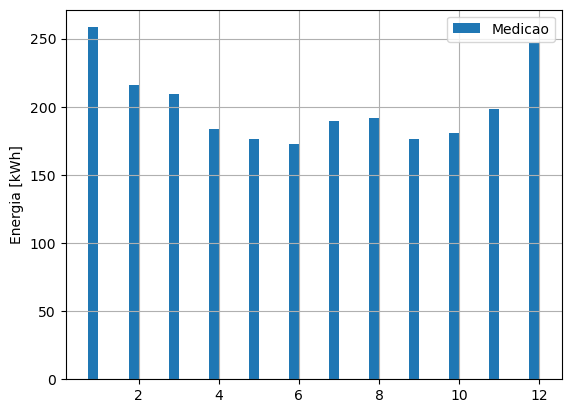

In [4]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width, label='Medicao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## 2. Produção

Produção estimada através do PV GIS

In [5]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

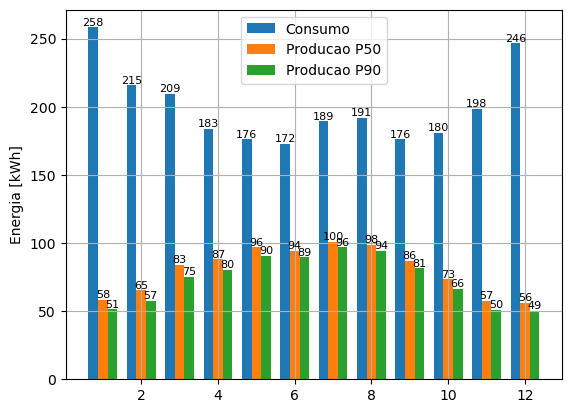

In [6]:
producao_mensal = producao.resample('M').sum()

fig, ax = plt.subplots()

width = 0.50
c = ax.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width/2, label='Consumo')
ax.bar_label(c, fmt='%d', fontsize=8)
p = ax.bar(producao_mensal.index.month, producao_mensal['autoproducao'], width=width/2, label='Producao P50')
ax.bar_label(p, fmt='%d', fontsize=8)
p1 = ax.bar(producao_mensal.index.month+width/2, producao_mensal['autoproducao_p90'], width=width/2, label='Producao P90')
ax.bar_label(p1, fmt='%d', fontsize=8)
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

## 3. Análise Energético do Projecto

Considerar sistema de armazenamento com estado de carga (SOC) minimo de 20% e máximo de 80% para maximizar tempo de vida da bateria. 

In [7]:
energia_armaz = []

if analise_com_bateria:
    bat = bateria.bateria(capacidade_bat, soc_min, soc_max)
    bat_p90 = bateria.bateria(capacidade_bat, soc_min, soc_max)

    # data frames com armazenamento
    energia_armaz = consumo['consumo'].to_frame('consumo')
    energia_armaz = energia_armaz.join(producao, how="outer")

    energia_armaz = ae.analisa_upac_com_armazenamento(energia_armaz, bat, True, bat_p90)

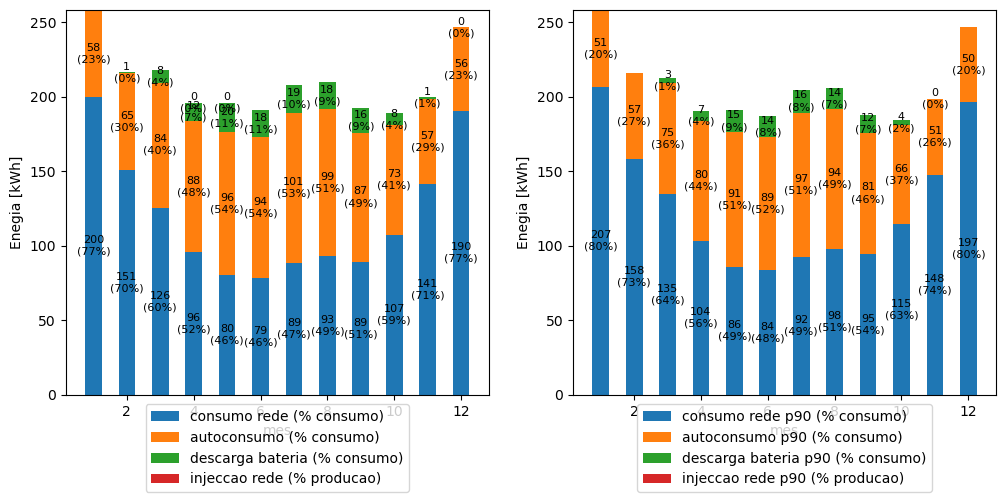

In [8]:
if analise_com_bateria:
    energia_armaz_mensal = energia_armaz.resample('M').sum()

    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    # plot mean P50
    ae.plot_energia_mensal_bars(ax1, energia_armaz_mensal, consumo_mensal, producao_mensal["autoproducao"], ["consumo_rede", "autoconsumo", "injeccao_rede", "descarga_bateria"])

    # plot P90
    ae.plot_energia_mensal_bars(ax2, energia_armaz_mensal, consumo_mensal, producao_mensal["autoproducao_p90"], ["consumo_rede_p90", "autoconsumo_p90", "injeccao_rede_p90", "descarga_bateria_p90"])


In [9]:
if analise_com_bateria:
    indicadores_armaz, indicadores_armaz_p90 = ae.calcula_indicadores_autoconsumo_com_armazenamento(energia_armaz, bat, capacidade_instalada, True, bat_p90)
    ae.print_tabela_indicadores_html(indicadores_armaz, indicadores_armaz_p90)

,P50,P90
Potencia Instalada,0.60 kW,0.60 kW
Energia Autoproduzida [kWh],959.8,883.8
Energia Autoconsumida [kWh],958.3,883.6
Energia consumida rede [kWh],1441.7,1516.4
Energia consumida [kWh],2400.0,2400.0
Numero de horas equivalentes [h/ano],1599.6,1473.1
IAS: Contributo PV [%],39.9,36.8
IAC: Indice Auto consumo [%],99.8,100.0
IER: Producao PV desperdicada [%],0.2,0.0
Bateria:,,


## 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

### 4.1 UPAC sem venda à rede

In [10]:
if analise_com_bateria:
    # custos tarifario simples
    mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede'])
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

    mensal_simples_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede_p90'])
    simples_styler_p90 = mensal_simples_p90.style.format("{:.2f} €").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + simples_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,52.07 €,40.65 €,11.42 €
Fevereiro,43.90 €,31.17 €,12.73 €
Março,42.53 €,26.08 €,16.45 €
Abril,37.54 €,20.41 €,17.13 €
Maio,35.99 €,17.56 €,18.43 €
Junho,35.41 €,17.29 €,18.12 €
Julho,38.55 €,19.07 €,19.48 €
Agosto,39.07 €,19.90 €,19.17 €
Setembro,36.01 €,19.18 €,16.83 €


In [11]:
if analise_com_bateria:
    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede'])
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

    mensal_bihorario_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede_p90'])
    bihorario_styler_p90 = mensal_bihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")
    display_html(bihorario_styler._repr_html_() + bihorario_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,51.77 €,38.46 €,13.31 €
Fevereiro,43.45 €,28.64 €,14.81 €
Março,42.25 €,23.24 €,19.01 €
Abril,37.30 €,17.65 €,19.65 €
Maio,35.71 €,14.56 €,21.15 €
Junho,35.00 €,14.26 €,20.74 €
Julho,38.08 €,15.71 €,22.37 €
Agosto,38.60 €,16.56 €,22.04 €
Setembro,35.67 €,16.33 €,19.34 €


In [13]:
if analise_com_bateria:
    mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede'], ano_tarifario)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

    mensal_trihorario_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede_p90'], ano_tarifario)
    trihorario_style_p90 = mensal_trihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")

    display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,59.70 €,44.38 €,15.32 €
Fevereiro,49.93 €,32.92 €,17.01 €
Março,47.17 €,24.91 €,22.26 €
Abril,37.04 €,14.34 €,22.70 €
Maio,35.14 €,11.46 €,23.68 €
Junho,34.30 €,11.09 €,23.21 €
Julho,37.18 €,12.09 €,25.09 €
Agosto,37.72 €,12.82 €,24.90 €
Setembro,35.10 €,13.07 €,22.03 €


### 4.2 UPAC com venda à rede

In [14]:
if analise_com_bateria:
    # simples
    mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

    mensal_simples_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'])
    simples_styler_p90 = mensal_simples_p90.style.format("{:.2f} €").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + simples_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,52.07 €,40.65 €,11.42 €,0.00 €
Fevereiro,43.90 €,31.17 €,12.73 €,0.00 €
Março,42.53 €,26.08 €,16.45 €,0.00 €
Abril,37.54 €,20.41 €,17.13 €,0.00 €
Maio,35.99 €,17.56 €,18.45 €,0.02 €
Junho,35.41 €,17.29 €,18.12 €,0.00 €
Julho,38.55 €,19.07 €,19.48 €,0.00 €
Agosto,39.07 €,19.90 €,19.17 €,0.00 €
Setembro,36.01 €,19.18 €,16.83 €,0.00 €


In [15]:
if analise_com_bateria:
    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

    mensal_bihorario_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'])
    bihorario_styler_p90 = mensal_bihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
    display_html(bihorario_styler._repr_html_() + bihorario_styler_p90._repr_html_(), raw=True)


,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,51.77 €,38.46 €,13.31 €,0.00 €
Fevereiro,43.45 €,28.64 €,14.81 €,0.00 €
Março,42.25 €,23.24 €,19.01 €,0.00 €
Abril,37.30 €,17.65 €,19.65 €,0.00 €
Maio,35.71 €,14.56 €,21.17 €,0.02 €
Junho,35.00 €,14.26 €,20.74 €,0.00 €
Julho,38.08 €,15.71 €,22.37 €,0.00 €
Agosto,38.60 €,16.56 €,22.04 €,0.00 €
Setembro,35.67 €,16.33 €,19.34 €,0.00 €


In [16]:
if analise_com_bateria:
    mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'], ano_tarifario)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")
    
    mensal_trihorario_p90 = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'], ano_tarifario)
    trihorario_style_p90 = mensal_trihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")
    display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,59.70 €,44.38 €,15.32 €,0.00 €
Fevereiro,49.93 €,32.92 €,17.01 €,0.00 €
Março,47.17 €,24.91 €,22.26 €,0.00 €
Abril,37.04 €,14.34 €,22.70 €,0.00 €
Maio,35.14 €,11.46 €,23.70 €,0.02 €
Junho,34.30 €,11.09 €,23.21 €,0.00 €
Julho,37.18 €,12.09 €,25.09 €,0.00 €
Agosto,37.72 €,12.82 €,24.90 €,0.00 €
Setembro,35.10 €,13.07 €,22.03 €,0.00 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [17]:
investimento_estimado = custo_pv + custo_instalacao + outros_custos

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

### 5.1 UPAC sem venda à rede

In [18]:
cols = ['consumo', 'consumo_rede']
cols_p90 = ['consumo', 'consumo_rede_p90']

# custos tarifario simples
indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols, indicadores_armaz)
simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_simples_p90, cf_simples_p90 = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols_p90, indicadores_armaz)
simples_style_p90 = indicadores_financas_simples_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
display_html(simples_style._repr_html_() + simples_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1377.36
TIR [%],12.39
Retorno do investimento [anos],10.30
Lcoe [€/kWh],0.13
,valores
indice,


In [19]:
# custos tarifario bi-horario
indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols, indicadores_armaz)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario_p90, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols_p90, indicadores_armaz)
bihorario_style_p90 = indicadores_financas_bihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
display_html(bihorario_style._repr_html_() + bihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1798.79
TIR [%],14.43
Retorno do investimento [anos],8.70
Lcoe [€/kWh],0.13
,valores
indice,


In [21]:
# custos tarifario tri-horario
indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols, indicadores_armaz)
trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_trihorario_p90, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols_p90, indicadores_armaz)
trihorario_style_p90 = indicadores_financas_trihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")

display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],2338.11
TIR [%],16.85
Retorno do investimento [anos],7.30
Lcoe [€/kWh],0.13
,valores
indice,
